#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    """
    Вычисляет значение функции потерь Elastic Net для логистической регрессии
    с метками y ∈ {0, 1}.

    Параметры:
    X: Список списков или np.ndarray (n_objects, n_features)
    y: Список или np.ndarray (n_objects,) с метками 0 или 1
    w: Список весов (n_features,)
    w0: смещение (intercept)
    gamma: коэффициент L1-регуляризации
    beta: коэффициент L2-регуляризации

    Возвращает:
    float: значение функции потерь
    """
    n_samples = len(y)
    if n_samples == 0:
        return 0.0

    log_loss_sum = 0.0
    for i in range(n_samples):
        z_i = w0
        for j in range(len(w)):
            z_i += w[j] * X[i][j]

        if z_i > 0:
            log_term = z_i + math.log(1 + math.exp(-z_i))
        else:
            log_term = math.log(1 + math.exp(z_i))

        log_loss_sum += log_term - y[i] * z_i

    # Усредняем логистическую часть
    avg_log_loss = log_loss_sum / n_samples

    # L1-регуляризация: gamma * ||w||_1
    l1_penalty = gamma * sum(abs(weight) for weight in w)

    # L2-регуляризация: beta * ||w||_2^2
    l2_penalty = beta * sum(weight * weight for weight in w)

    total_loss = avg_log_loss + l1_penalty + l2_penalty
    return total_loss

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    :return: Tuple[List[float], float] -- (grad_w, grad_w0)
    '''
    # Преобразуем входы в списки/массивы Python (если они не таковы)
    # X: предполагаем список списков [[x11, x12, ...], [x21, x22, ...], ...]
    # y: список [y1, y2, ...]
    # w: список [w1, w2, ...]
    N = len(y)
    if N == 0:
        K = len(w)
        return [0.0] * K, 0.0
    K = len(X[0]) # Предполагаем, что X не пустой и все строки одинаковой длины

    unique_y_values = set()
    for val in y:
        unique_y_values.add(val)
    is_01 = unique_y_values.issubset({0, 1})

    s = []
    for i in range(N):
        s_i = w0
        for j in range(K):
            s_i += w[j] * X[i][j]
        s.append(s_i)

    # --- Вычисление common ---
    common = []
    if is_01:
        for i in range(N):
            y_val = y[i]
            s_val = s[i]
            y_s_prod = y_val * s_val
            try:
                denom = 1.0 + exp_safe(y_s_prod) # exp_safe определена ниже
            except OverflowError:
                common_val = 0.0
            else:
                common_val = - (y_val / denom)
            common.append(common_val)
    else:
        for i in range(N):
            y_val = y[i]
            s_val = s[i]
            y_s_prod = y_val * s_val
            try:
                denom = 1.0 + exp_safe(y_s_prod)
            except OverflowError:
                common_val = 0.0
            else:
                common_val = - y_val / denom
            common.append(common_val)

    grad_w = [0.0] * K
    for j in range(K):
        for i in range(N):
            grad_w[j] += X[i][j] * common[i]
        grad_w[j] /= N

    grad_w0 = sum(common) / N

    def sign(x):
        if x > 0:
            return 1.0
        elif x < 0:
            return -1.0
        else:
            return 0.0

    grad_w_reg = []
    for j in range(K):
        grad_w_reg.append(grad_w[j] + gamma * sign(w[j]) + 2.0 * beta * w[j])

    return grad_w_reg, grad_w0

# Вспомогательная функция для безопасного вычисления exp
def exp_safe(x):
    if x > 700: # Добавим небольшой запас
        return float('inf')
    elif x < -700:
        return 0.0
    else:
        return math.exp(x)

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        """
        Инициализация модели логистической регрессии.

        Параметры:
        beta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge
        random_state: seed for random number generator
        """
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state

        # Инициализация весов и смещения
        self.w_ = None
        self.w0_ = None
        # Добавляем атрибут для хранения истории потерь
        self.loss_history_ = []

    def fit(self, X, y):
        """
        Обучение модели методом SGD.

        Параметры:
        X: np.ndarray of shape (n_objects, n_features)
        y: np.ndarray of shape (n_objects,) with labels 0 or 1
        """
        # Сохраняем размерность данных
        n_samples, n_features = X.shape

        # Инициализация весов случайными значениями
        np.random.seed(self.random_state)
        self.w_ = np.random.normal(size=n_features).tolist()  # Приводим к списку
        self.w0_ = np.random.normal()

        # Преобразуем X и y в списки списков и списки для совместимости с функциями
        X_list = X.tolist() if isinstance(X, np.ndarray) else X
        y_list = y.tolist() if isinstance(y, np.ndarray) else y

        # Очистка истории потерь
        self.loss_history_ = []

        # Метод SGD
        for iteration in range(self.max_iter):
            # Вычисляем градиент
            grad_w, grad_w0 = get_grad(X_list, y_list, self.w_, self.w0_, self.gamma, self.beta)

            # Вычисляем значение потерь на текущей итерации
            current_loss = loss(X_list, y_list, self.w_, self.w0_, self.gamma, self.beta)
            self.loss_history_.append(current_loss)

            # Обновляем веса и смещение
            new_w = [self.w_[j] - self.lr * grad_w[j] for j in range(len(self.w_))]
            new_w0 = self.w0_ - self.lr * grad_w0

            # Проверка на сходимость
            w_change = sum((new_w[j] - self.w_[j])**2 for j in range(len(self.w_)))**0.5
            w0_change = abs(new_w0 - self.w0_)
            total_change = w_change + w0_change

            if total_change < self.tolerance:
                break

            # Обновляем веса
            self.w_ = new_w
            self.w0_ = new_w0

        return self

    def predict_proba(self, X):
        """
        Функция, которая оценивает вероятности принадлежности объектов к классу 1.

        Параметры:
        X: np.ndarray of shape (n_objects, n_features)

        Возвращает:
        np.ndarray of shape (n_objects,) -- вектор вероятностей
        """
        X_list = X.tolist() if isinstance(X, np.ndarray) else X

        probabilities = []
        for i in range(len(X_list)):
            z_i = self.w0_
            for j in range(len(self.w_)):
                z_i += self.w_[j] * X_list[i][j]

            if z_i >= 0:
                exp_neg_z = math.exp(-z_i)
                prob = 1.0 / (1.0 + exp_neg_z)
            else:
                exp_z = math.exp(z_i)
                prob = exp_z / (1.0 + exp_z)
            probabilities.append(prob)

        return np.array(probabilities)

    def predict(self, X):
        """
        Функция, которая возвращает вектор предсказанных меток для каждого объекта из X.

        Параметры:
        X: np.ndarray of shape (n_objects, n_features)

        Возвращает:
        np.ndarray of shape (n_objects,) -- вектор предсказанных меток (0 или 1)
        """
        probs = self.predict_proba(X)
        predictions = (probs >= 0.5).astype(int)
        return predictions

In [7]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [8]:
def plot_decision_boundary(model, X, y):
    """
    Функция, которая отрисовывает объекты датасета, их метки и
    разделяющую гиперплоскость, полученную от Логистической регрессии.

    Параметры:
    model: обученная модель Logit
    X: np.ndarray of shape (n_objects, 2) -- матрица объектов-признаков (только 2 признака!)
    y: np.ndarray of shape (n_objects,) -- вектор меток (ожидается -1 или 1)
    """
    # Проверка, что у нас ровно 2 признака
    if X.shape[1] != 2:
        raise ValueError("X должен иметь ровно 2 признака для построения границы решения.")

    # Получаем веса и смещение из обученной модели
    w = model.w_  # Список весов [w1, w2]
    w0 = model.w0_ # Смещение

    # Создаем сетку для построения границы
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                           np.linspace(x2_min, x2_max, 200))

    # Вычисляем значение линейной комбинации на сетке
    Z = w0 + w[0] * xx1 + w[1] * xx2

    plt.figure(figsize=(8, 6))

    # Отрисовываем точки
    mask_neg = y == -1
    mask_pos = y == 1
    plt.scatter(X[mask_neg, 0], X[mask_neg, 1], c='black', edgecolors='black', label='Class -1')
    plt.scatter(X[mask_pos, 0], X[mask_pos, 1], c='white', edgecolors='black', label='Class 1')

    # Отрисовываем границу решения
    contour = plt.contour(xx1, xx2, Z, levels=[0], colors='red', linewidths=2)

    # Заливка областей
    plt.contourf(xx1, xx2, Z, levels=[-np.inf, 0, np.inf], colors=['lightblue', 'lightcoral'], alpha=0.3)

    # Добавляем легенду и подписи
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary of Logistic Regression')
    plt.legend()
    plt.grid(True)
    plt.axis('equal') # Для одинакового масштаба осей
    plt.show()


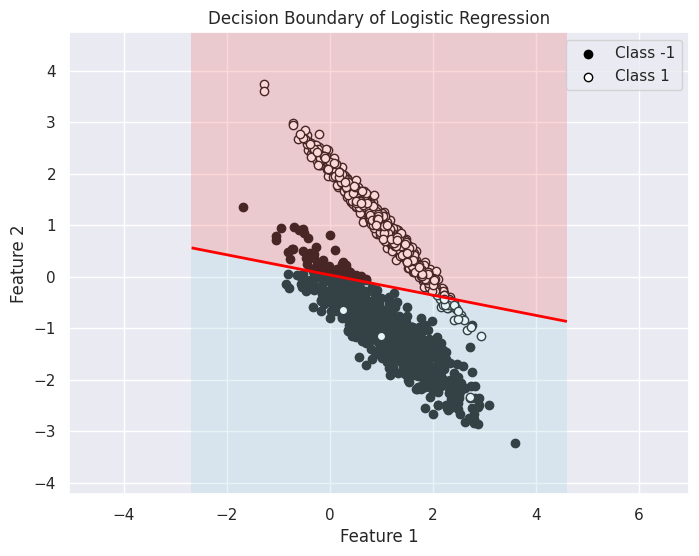

In [9]:
model1 = Logit(0, 0)  # Без регуляризации
y_copy = y.copy()     # Создаем копию, чтобы не изменять оригинальный y
y_copy[y_copy == 0] = -1  # Преобразуем 0 в -1
model1.fit(X, y_copy)      # Обучаем модель
plot_decision_boundary(model1, X, y_copy)  # Рисуем границу

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [10]:
def plot_loss_history(model):
    """
    Функция, которая отображает на графике, как изменяется значение функции потерь от номера итерации.

    Параметры:
    model: обученная модель Logit, у которой есть атрибут loss_history_
    """
    if not hasattr(model, 'loss_history_') or len(model.loss_history_) == 0:
        print("Модель не была обучена или history потерь пуст.")
        return

    # Создаем график
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(model.loss_history_) + 1), model.loss_history_, marker='o', linestyle='-', color='blue')
    plt.xlabel('Номер итерации')
    plt.ylabel('Значение функции потерь')
    plt.title('Изменение функции потерь по итерациям')
    plt.grid(True)
    plt.show()

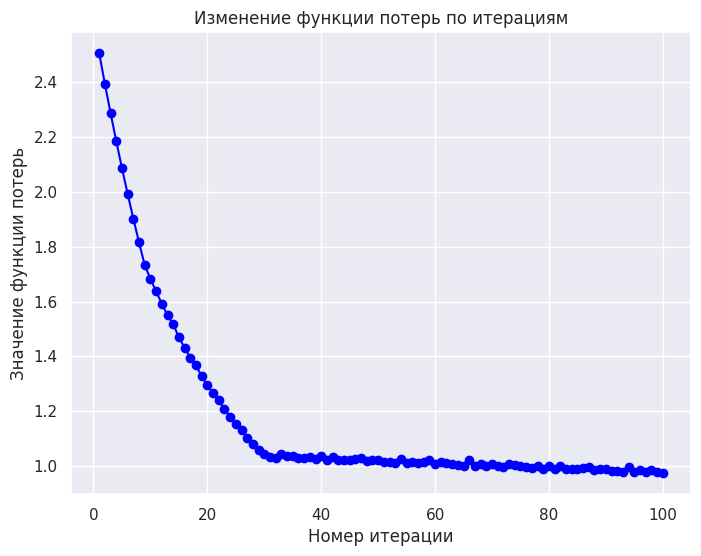

In [11]:
model1 = Logit(beta=1.0, gamma=1.0, lr=1e-2, max_iter=100)
y_copy = y.copy()     # Создаем копию, чтобы не изменять оригинальный y
y_copy[y_copy == 0] = -1  # Преобразуем 0 в -1
model1.fit(X, y_copy)      # Обучаем модель (теперь loss_history_ заполнится)
plot_loss_history(model1)  # Рисуем график изменения потерь

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Список ядер и значений C для перебора ---
kernels = ['linear', 'rbf', 'poly']  # Можно добавить 'sigmoid'
C_values = [0.1, 1.0, 10.0]

# --- Словарь для хранения результатов ---
results = []

# --- Обучение и оценка SVC ---
for kernel in kernels:
    for C in C_values:
        print(f"\n--- SVM с kernel='{kernel}', C={C} ---")

        # Создаем и обучаем модель SVC
        svc = SVC(kernel=kernel, C=C, probability=True, random_state=42)  # probability=True для AUC-ROC
        svc.fit(X_train, y_train)

        # Делаем предсказания
        y_pred = svc.predict(X_test)
        y_proba = svc.predict_proba(X_test)[:, 1]  # Вероятности класса 1

        # Вычисляем метрики
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='binary')  # Для бинарной классификации
        rec = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        auc_roc = roc_auc_score(y_test, y_proba)

        # Сохраняем результаты
        results.append({
            'kernel': kernel,
            'C': C,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'AUC-ROC': auc_roc
        })

df_results = pd.DataFrame(results)
print(df_results.round(4).to_string(index=False))

#         # Выводим результаты
#         print(f"Accuracy: {acc:.4f}")
#         print(f"Precision: {prec:.4f}")
#         print(f"Recall: {rec:.4f}")
#         print(f"F1-Score: {f1:.4f}")
#         print(f"AUC-ROC: {auc_roc:.4f}")

# # --- Выводим таблицу результатов ---
# print("\n" + "="*80)
# print("Сводная таблица результатов:")
# print("="*80)
# print(f"{'Kernel':<8} {'C':<5} {'Acc':<7} {'Prec':<7} {'Rec':<7} {'F1':<7} {'AUC':<7}")
# print("-"*80)
# for res in results:
#     print(f"{res['kernel']:<8} {res['C']:<5} {res['Accuracy']:<7.4f} {res['Precision']:<7.4f} "
#           f"{res['Recall']:<7.4f} {res['F1-Score']:<7.4f} {res['AUC-ROC']:<7.4f}")



--- SVM с kernel='linear', C=0.1 ---

--- SVM с kernel='linear', C=1.0 ---

--- SVM с kernel='linear', C=10.0 ---

--- SVM с kernel='rbf', C=0.1 ---

--- SVM с kernel='rbf', C=1.0 ---

--- SVM с kernel='rbf', C=10.0 ---

--- SVM с kernel='poly', C=0.1 ---

--- SVM с kernel='poly', C=1.0 ---

--- SVM с kernel='poly', C=10.0 ---
kernel    C  Accuracy  Precision  Recall  F1-Score  AUC-ROC
linear  0.1    0.9944     0.9924  0.9962    0.9943   0.9986
linear  1.0    0.9944     0.9924  0.9962    0.9943   0.9989
linear 10.0    0.9944     0.9924  0.9962    0.9943   0.9990
   rbf  0.1    0.9944     0.9924  0.9962    0.9943   0.9989
   rbf  1.0    0.9944     0.9924  0.9962    0.9943   0.9985
   rbf 10.0    0.9944     0.9924  0.9962    0.9943   0.9950
  poly  0.1    0.9944     0.9924  0.9962    0.9943   0.9938
  poly  1.0    0.9944     0.9924  0.9962    0.9943   0.9946
  poly 10.0    0.9944     0.9924  0.9962    0.9943   0.9940


#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [13]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class HingeLossClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, lambda_=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        """
        Инициализация классификатора с Hinge Loss.

        Параметры:
        lambda_: коэффициент L2-регуляризации
        lr: learning rate (шаг градиентного спуска)
        tolerance: минимальное изменение весов для остановки
        max_iter: максимальное число итераций
        random_state: seed для воспроизводимости
        """
        self.lambda_ = lambda_
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w_ = None
        self.w0_ = None
        self.loss_history_ = []  # Для отрисовки

    def fit(self, X, y):
        """
        Обучение модели методом градиентного спуска.

        Параметры:
        X: np.ndarray of shape (n_objects, n_features)
        y: np.ndarray of shape (n_objects,) with labels -1 or 1
        """
        n_samples, n_features = X.shape

        # Инициализация весов случайными значениями
        np.random.seed(self.random_state)
        self.w_ = np.random.normal(size=n_features)
        self.w0_ = np.random.normal()

        # Метод градиентного спуска
        for iteration in range(self.max_iter):
            # Вычисляем градиент
            grad_w, grad_w0 = self._compute_gradient(X, y)

            # Вычисляем значение потерь (для истории)
            current_loss = self._compute_loss(X, y)
            self.loss_history_.append(current_loss)

            # Обновляем веса и смещение
            new_w = self.w_ - self.lr * grad_w
            new_w0 = self.w0_ - self.lr * grad_w0

            # Проверка на сходимость
            w_change = np.linalg.norm(new_w - self.w_)
            w0_change = abs(new_w0 - self.w0_)
            total_change = w_change + w0_change

            if total_change < self.tolerance:
                break

            # Обновляем веса
            self.w_ = new_w
            self.w0_ = new_w0

        return self

    def _compute_loss(self, X, y):
        """
        Вычисляет значение функции потерь Hinge Loss с L2-регуляризацией.
        """
        n_samples = len(y)
        hinge_loss_sum = 0.0

        for i in range(n_samples):
            z_i = self.w0_ + np.dot(self.w_, X[i])
            margin = y[i] * z_i
            hinge_loss_sum += max(0, 1 - margin)

        avg_hinge_loss = hinge_loss_sum / n_samples
        l2_penalty = self.lambda_ * np.sum(self.w_ ** 2)

        return avg_hinge_loss + l2_penalty

    def _compute_gradient(self, X, y):
        """
        Вычисляет градиент функции потерь Hinge Loss с L2-регуляризацией.
        """
        n_samples, n_features = X.shape
        grad_w = np.zeros(n_features)
        grad_w0 = 0.0

        for i in range(n_samples):
            z_i = self.w0_ + np.dot(self.w_, X[i])
            margin = y[i] * z_i

            if margin < 1:  # Только если объект внутри зазора или неправильно классифицирован
                grad_w -= y[i] * X[i]  # Градиент по w
                grad_w0 -= y[i]         # Градиент по w0

        # Усреднение градиента по всем объектам
        grad_w /= n_samples
        grad_w0 /= n_samples

        # Добавление градиента от L2-регуляризации
        grad_w += 2.0 * self.lambda_ * self.w_

        return grad_w, grad_w0

    def predict(self, X):
        """
        Предсказание меток для новых объектов.

        Параметры:
        X: np.ndarray of shape (n_objects, n_features)

        Возвращает:
        np.ndarray of shape (n_objects,) -- вектор предсказанных меток (-1 или 1)
        """
        scores = self.w0_ + np.dot(X, self.w_)
        predictions = np.sign(scores)  # Знак определяет класс
        return predictions.astype(int)


Accuracy: 0.9672
Precision: 0.9605
Recall: 0.9744
F1-Score: 0.9674
AUC-ROC: 0.9920


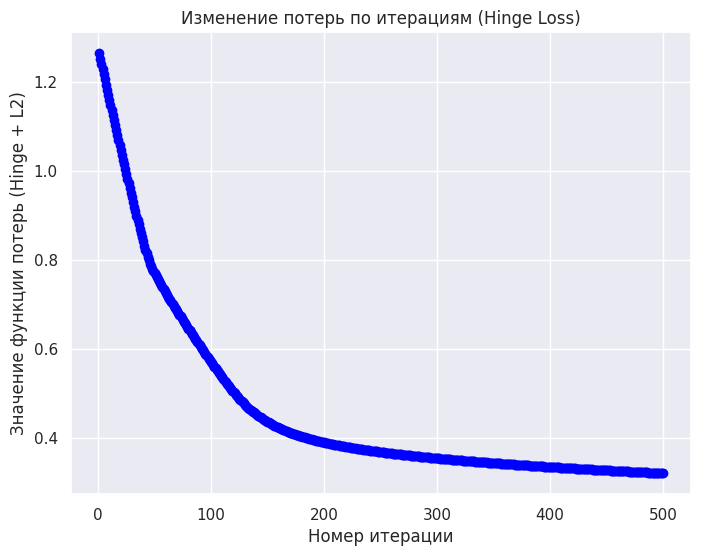

In [14]:
import matplotlib.pyplot as plt

# Преобразуем y в {-1, 1}, если он был {0, 1}
y_hinge = y.copy()
y_hinge[y_hinge == 0] = -1

# Создаем и обучаем модель
hinge_model = HingeLossClassifier(lambda_=0.1, lr=1e-2, max_iter=500)
hinge_model.fit(X, y_hinge)

# Делаем предсказания
y_pred_hinge = hinge_model.predict(X)

# Оцениваем метрики (можно использовать те же, что и для SVC)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

acc = accuracy_score(y_hinge, y_pred_hinge)
prec = precision_score(y_hinge, y_pred_hinge, average='binary')
rec = recall_score(y_hinge, y_pred_hinge, average='binary')
f1 = f1_score(y_hinge, y_pred_hinge, average='binary')

scores = hinge_model.w0_ + np.dot(X, hinge_model.w_)
auc_roc = roc_auc_score(y_hinge, scores)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(hinge_model.loss_history_) + 1), hinge_model.loss_history_, marker='o', linestyle='-', color='blue')
plt.xlabel('Номер итерации')
plt.ylabel('Значение функции потерь (Hinge + L2)')
plt.title('Изменение потерь по итерациям (Hinge Loss)')
plt.grid(True)
plt.show()

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [15]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='euclidean'):
        """
        Инициализация классификатора k-NN.

        Параметры:
        n_neighbors: количество ближайших соседей
        metric: метрика расстояния ('euclidean' или 'manhattan')
        """
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train_ = None
        self.y_train_ = None

    def fit(self, X, y):
        """
        Обучение модели — просто сохраняем обучающие данные.

        Параметры:
        X: np.ndarray of shape (n_objects, n_features)
        y: np.ndarray of shape (n_objects,) -- вектор меток
        """
        self.X_train_ = np.array(X)
        self.y_train_ = np.array(y)
        return self

    def predict(self, X):
        """
        Предсказание меток для новых объектов.

        Параметры:
        X: np.ndarray of shape (n_objects, n_features)

        Возвращает:
        np.ndarray of shape (n_objects,) -- вектор предсказанных меток
        """
        predictions = []
        for x in X:
            # Вычисляем расстояния до всех обучающих объектов
            distances = self._compute_distances(x, self.X_train_)

            # Находим индексы k ближайших соседей
            neighbor_indices = np.argsort(distances)[:self.n_neighbors]

            # Получаем метки соседей
            neighbor_labels = self.y_train_[neighbor_indices]

            # Находим самый частый класс
            unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
            predicted_label = unique_labels[np.argmax(counts)]

            predictions.append(predicted_label)

        return np.array(predictions)

    def predict_proba(self, X):
        """
        Предсказание вероятностей для новых объектов.

        Параметры:
        X: np.ndarray of shape (n_objects, n_features)

        Возвращает:
        np.ndarray of shape (n_objects, n_classes) -- матрица вероятностей
        """
        n_samples = len(X)
        # Определяем уникальные классы
        unique_classes = np.unique(self.y_train_)
        n_classes = len(unique_classes)

        proba_matrix = np.zeros((n_samples, n_classes))

        for i, x in enumerate(X):
            # Вычисляем расстояния
            distances = self._compute_distances(x, self.X_train_)

            # Находим индексы k ближайших соседей
            neighbor_indices = np.argsort(distances)[:self.n_neighbors]

            # Получаем метки соседей
            neighbor_labels = self.y_train_[neighbor_indices]

            # Считаем долю соседей для каждого класса
            for j, cls in enumerate(unique_classes):
                count = np.sum(neighbor_labels == cls)
                proba_matrix[i, j] = count / self.n_neighbors

        return proba_matrix

    def _compute_distances(self, x, X_train):
        """
        Вычисляет расстояния от одного объекта x до всех объектов в X_train.

        Параметры:
        x: np.ndarray of shape (n_features,)
        X_train: np.ndarray of shape (n_train_objects, n_features)

        Возвращает:
        np.ndarray of shape (n_train_objects,) -- вектор расстояний
        """
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((X_train - x) ** 2, axis=1))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(X_train - x), axis=1)
        else:
            raise ValueError(f"Неизвестная метрика: {self.metric}")


In [16]:
# Разделяем на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Создаем и обучаем модель KNN
knn = KNNClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

# Делаем предсказания
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]  # Вероятности для класса 1

# Вычисляем метрики
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='binary')  # Для бинарной задачи
rec = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
auc_roc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Можно также попробовать разные метрики и k
for k in [3, 5, 7]:
    knn_k = KNNClassifier(n_neighbors=k, metric='euclidean')
    knn_k.fit(X_train, y_train)
    y_pred_k = knn_k.predict(X_test)
    y_proba_k = knn_k.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba_k)
    print(f"k={k}, AUC-ROC: {auc:.4f}")

Accuracy: 0.9944
Precision: 0.9924
Recall: 0.9962
F1-Score: 0.9943
AUC-ROC: 0.9944
k=3, AUC-ROC: 0.9945
k=5, AUC-ROC: 0.9944
k=7, AUC-ROC: 0.9944


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
import pandas as pd
from sklearn.utils import shuffle

# --- 1. Прочитать файлы ---
df_train = pd.read_csv('fashion-mnist_train.csv')
df_test = pd.read_csv('fashion-mnist_test.csv')

print(f"Размер исходного трейна: {len(df_train)} строк") # Ожидается 60000
print(f"Размер исходного теста: {len(df_test)} строк")   # Ожидается 10000

# --- 2. Объединить ---
# Объединяем по строкам
df_combined = pd.concat([df_train, df_test], ignore_index=True)

print(f"Размер объединенного датафрейма: {len(df_combined)} строк") # Ожидается 70000

# --- 3. Перемешать ---
# Перемешиваем строки
df_shuffled = shuffle(df_combined, random_state=42)

# --- 4. Разделить на train_size=50000 и test_size=10000 ---
train_size = 50000
test_size = 10000

# Проверяем, хватает ли данных
total_rows = len(df_shuffled)
required_rows = train_size + test_size
if total_rows < required_rows:
    print(f"Внимание: Объединённый датафрейм содержит {total_rows} строк.")
    print(f"Для train_size={train_size} и test_size={test_size} нужно {required_rows} строк.")
    print("Разделение невозможно по требуемой пропорции.")
else:
    # Создаем новые датафреймы
    df_new_train = df_shuffled.iloc[:train_size].copy()
    df_new_test = df_shuffled.iloc[train_size : train_size + test_size].copy()

print(f"Размер нового трейна: {len(df_new_train)} строк")
print(f"Размер нового теста: {len(df_new_test)} строк")

# --- 5. (Опционально) Сохранить новые файлы ---
df_new_train.to_csv('new_fashion_train_50k.csv', index=False)
df_new_test.to_csv('new_fashion_test_10k.csv', index=False)

Размер исходного трейна: 60000 строк
Размер исходного теста: 10000 строк
Размер объединенного датафрейма: 70000 строк
Размер нового трейна: 50000 строк
Размер нового теста: 10000 строк


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

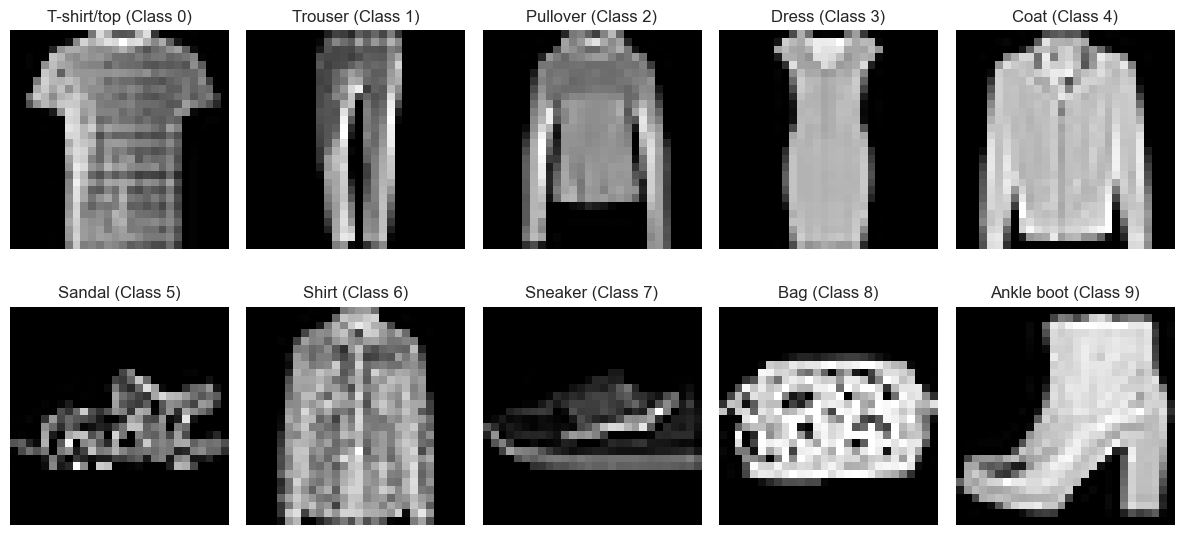

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Загрузите данные (если еще не загружены) ---
# Предположим, что у вас есть объединенный датафрейм или вы можете использовать train/test
df = pd.read_csv('new_fashion_train_50k.csv')

# --- 2. Определите метки классов и их названия (опционально, для подписей) ---
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# --- 3. Для каждого класса выберите одно изображение ---
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()  # Превращаем 2x5 в 1D массив

for class_idx in range(10):
    # Фильтруем строки с меткой class_idx
    class_df = df[df.iloc[:, 0] == class_idx]

    # Берем первую строку (или любую другую, например, случайную)
    sample_row = class_df.iloc[0]  # Можно заменить на .sample(1) для случайного выбора

    # Преобразуем пиксели в матрицу 28x28
    image = sample_row[1:].values.reshape(28, 28)  # Пропускаем первый столбец (метку)

    # Отображаем изображение
    ax = axes[class_idx]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{class_names[class_idx]} (Class {class_idx})')
    ax.axis('off')

plt.tight_layout()
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# --- 1. Загрузите данные ---
# Предположим, что у вас есть тренировочный датафрейм
df_train = pd.read_csv('new_fashion_train_50k.csv')

# --- 2. Разделите на метки и признаки ---
# Первый столбец — метка класса
y_train = df_train.iloc[:, 0]  # Метки

# Остальные столбцы — пиксели (признаки)
X_train = df_train.iloc[:, 1:]  # Матрица 60000 x 784

# --- 3. Примените StandardScaler ---
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)

# Проверим: среднее и стандартное отклонение по каждому признаку должны быть близки к 0 и 1
print("Статистика после StandardScaler:")
print(f"Среднее значение (по признакам): {X_train_std.mean(axis=0).mean():.4f}")
print(f"Стандартное отклонение (по признакам): {X_train_std.std(axis=0).mean():.4f}")

# --- 4. Примените MinMaxScaler ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))  # Масштабируем в [0, 1]
X_train_minmax = scaler_minmax.fit_transform(X_train)

# Проверим: минимальное и максимальное значения должны быть 0 и 1
print("\nСтатистика после MinMaxScaler:")
print(f"Минимальное значение: {X_train_minmax.min():.4f}")
print(f"Максимальное значение: {X_train_minmax.max():.4f}")


Статистика после StandardScaler:
Среднее значение (по признакам): -0.0000
Стандартное отклонение (по признакам): 1.0000

Статистика после MinMaxScaler:
Минимальное значение: 0.0000
Максимальное значение: 1.0000


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

В итоге обучения логистической регрессии на SGD вы получите модель которая предсказывает одну и ту же вероятность (примерно 0.5) для всех объектов, независимо от их истинного класса. Модель не сможет научиться различать классы, потому что все признаки одинаковы и не содержат никакой полезной информации для классификации.